In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *

In [3]:
who_df = pd.read_csv(Path("../data/interim/who_subnational_with_geocodes.csv"), index_col=0)
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,...,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,google_admin_1,google_admin_2,place_id
provenance,,,,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,...,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who1151,AFG,Afghanistan,EMRO,2016,Pol3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,Polio,Pol3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4


In [4]:
wb = pd.read_csv(Path("../data/interim/external-processed/country_world_bank_indicators.csv"), index_col=0)
wb.head()

,crude_birth_rate_2016,population_2016,infant_mortality_rate_2016
Country Code,,,
ABW,10.963,104822.0,NaN
AFG,33.980,34656032.0,53.2
AGO,42.321,28813463.0,54.6
ALB,11.879,2876101.0,12.0
AND,9.500,77281.0,2.4


In [5]:
per_region_denoms = (who_df.groupby(["Iso Code", 'google_admin_1', 'google_admin_2', 'DenomType'])
                           .Denominator  
                           .max()
                           .unstack(-1)
                           [[1, 2]])

per_region_denoms.head()

DenomType                                   1.0      2.0
Iso Code google_admin_1 google_admin_2                  
AFG      Badakhshan     Darwaz           4722.0   4384.0
                        Fayzabad        12784.0  11870.0
                        Jurm             4572.0   4246.0
                        Kalafgan         6668.0   6192.0
                        Khwahan           837.0    777.0

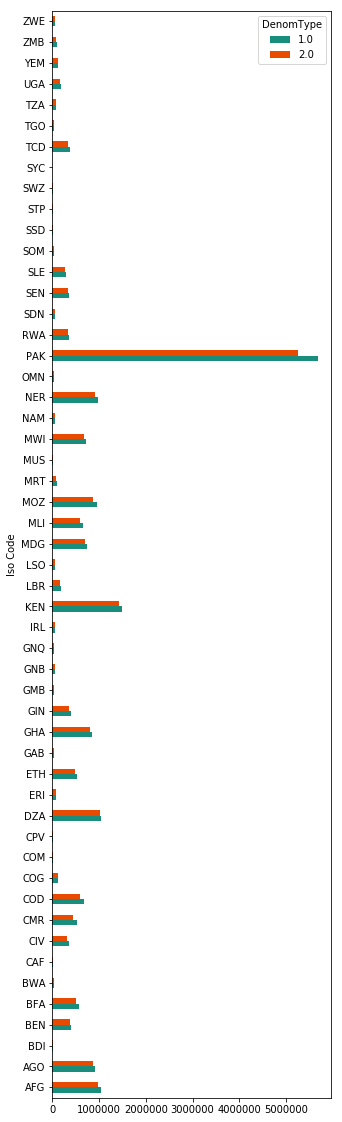

In [6]:
country_denoms = (per_region_denoms[[1, 2]]
                    .reset_index()
                    .groupby(['Iso Code'])
                    .sum()
                    .replace({0: np.nan})
                    .dropna(how='any'))

country_denoms.plot.barh(figsize=(5, 20))

In [7]:
remap = who_df[['Iso Code', 'Country Name']].drop_duplicates().set_index('Iso Code').to_dict()['Country Name']

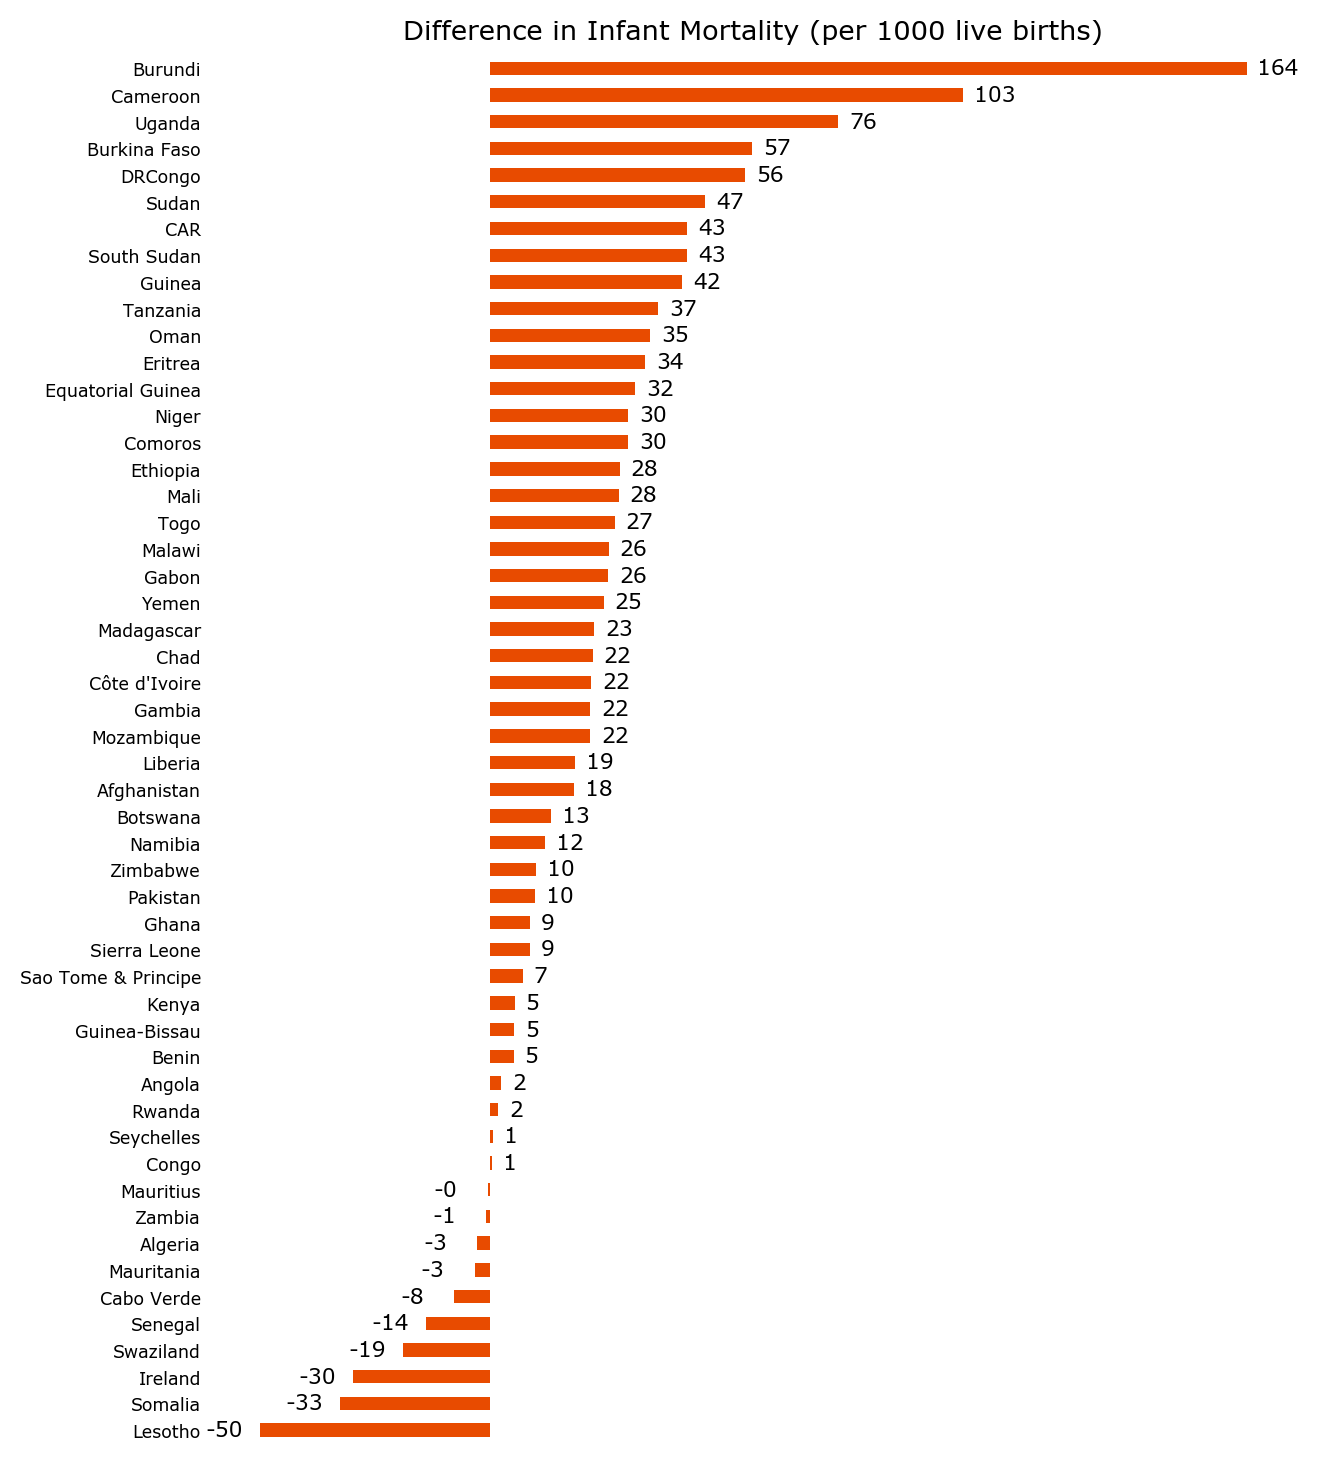

In [22]:
# sum births and infants at 1 by country

infant_mortality_err = (country_denoms.pipe(lambda x: 1000 * (x[1] - x[2]) / x[1])
                                      .to_frame()
                                      .join(wb).pipe(lambda x: (x[0] - x.infant_mortality_rate_2016)))

infant_mortality_err.name = 'infant_mortality_wb_diff'
infant_mortality_err.abs().to_frame().to_csv(Path('../data/processed/scores/country-wb-abs-infant_mortality.csv'))
        
to_plot = infant_mortality_err

with styled_fig_ax(size='tall', font_size=8, x_formatter=comma_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot[to_plot.sort_values().index].rename(index=remap),
                font_size=8,
                horizontal=True,
                label_formatter=comma_func_formatter(),
                color=PALETTE['orange']
               )
    

    ax.set_ylabel('')
    ax.set_title('Difference in Infant Mortality (per 1000 live births)')
    # to_plot[to_plot.abs().sort_values().index].rename(index=remap).plot.barh(figsize=(5, 20))

### Birth Rate Diff M

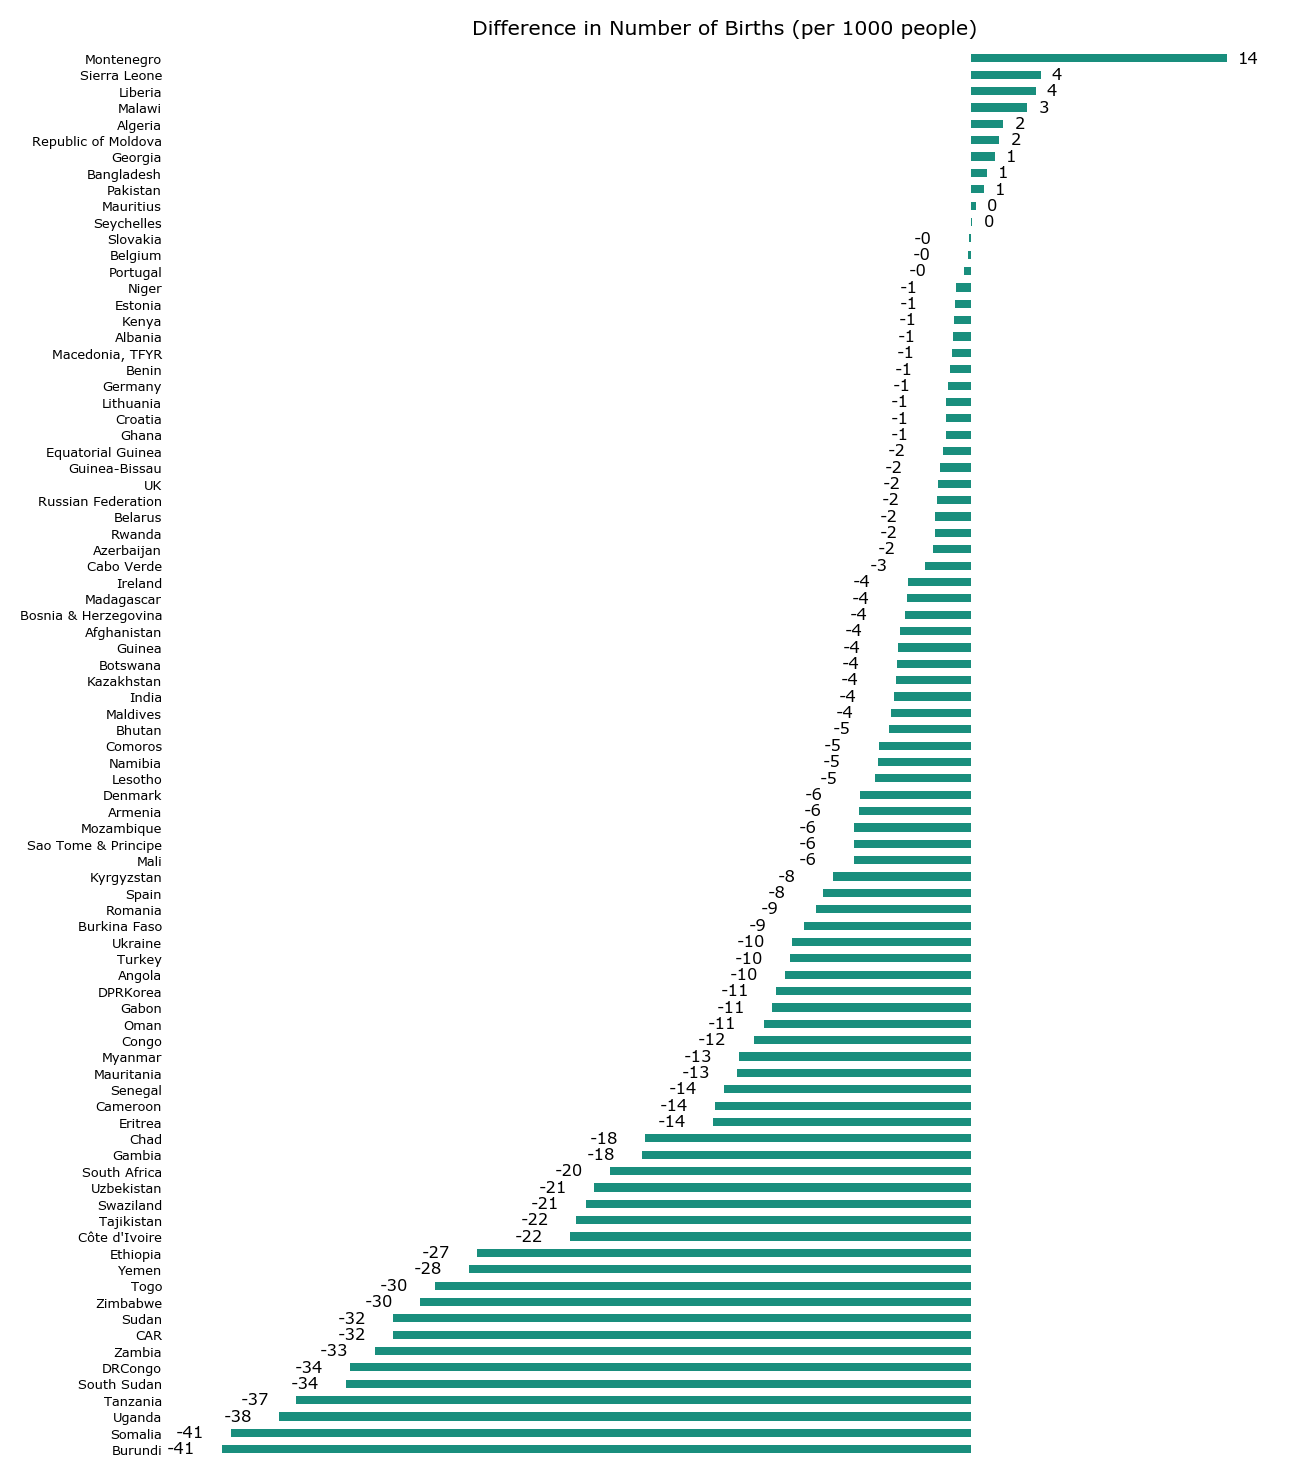

In [21]:
who_birth = who_df[who_df.DenomType == 1.0]


n_births = (who_birth.groupby(["Iso Code", 'google_admin_1', 'google_admin_2', 'DenomType'])
                       .Denominator  
                       .max()
                       .reset_index()
                       .groupby("Iso Code")
                       .Denominator
                       .sum()
                       .to_frame())


err_per_thou_births = (n_births.join(wb)
                         .assign(wb_births=lambda x: x.population_2016 * (x.crude_birth_rate_2016 / 1000))
                         .pipe(lambda x: 1000 * (x.Denominator - x.wb_births) / (x.population_2016)))


err_per_thou_births.name = 'crude_birth_rate_wb_diff'
err_per_thou_births.abs().to_frame().to_csv(Path('../data/processed/scores/country-wb-abs-crude_birth_rate.csv'))
        
to_plot = err_per_thou_births
# to_plot[to_plot.abs().sort_values().index].rename(index=remap).plot.barh(figsize=(5, 20))


with styled_fig_ax(size='tall', font_size=6, x_formatter=comma_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot[to_plot.sort_values().index].rename(index=remap),
                font_size=6,
                horizontal=True,
                label_formatter=comma_func_formatter(),
                color=PALETTE['green']
               )
    

    ax.set_ylabel('')
    ax.set_title('Difference in Number of Births (per 1000 people)')